# Statistical Rethinking Chapter 5
> Code rewitten in Python to briefly summarise the main takeaways in this chapter
- toc: true 
- badges: true
- comments: true
- categories: [statistical_rethinking]

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

## 6.1 Multicollinearity
X0 -> X1  
X0 -> X2  
X1 -> y <- X2  
> Important: Multicollinearity means very strong correlation between two or more predictor variables. The consequence of it is that the posterior distribution will seem to suggest that none of the variables is reliably associated with the outcome, even if all of the variables are in reality strongly associated with the outcome. This frustrating phenomenon arises from the details of how multiple regression works. In fact, there is nothing wrong with multicollinearity. The model will work fine for prediction. You will just be frustrated trying to understand it.  
Different disciplines have different conventions for dealing with collinear variables. In some fields, it is typical to engage in some kind of data reduction procedure, like **principle components** or **factor analysis**, and then to use the components/factors as predictor variables.

> Note: Above a correlation of 0.9, the standard deviation increases very rapidly, approaching in fact 1 as the correlation approaches 1

In [28]:
N = 100
np.random.seed(888)
height = np.random.normal(10, 2, N)
leg_prop = np.random.uniform(0.4, 0.5, N)
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)

d = pd.DataFrame({'height': height, 'leg_left': leg_left, 'leg_right': leg_right})
d.head()

,height,leg_left,leg_right
0,9.647598,4.747363,4.728460
1,10.377753,4.377797,4.355360
2,11.653494,4.785311,4.781032
3,9.935105,4.674601,4.697245
4,8.695001,3.814152,3.841337


In [30]:
X = d[['leg_left', 'leg_right']]
y = d['height']
N = 1000
with pm.Model() as model:
    # Since the outcome and the predictor are both standardized, the intercept should end up very close to zero
    a = pm.Normal('a', 10, 100)
    b = pm.Normal('b', 2, 0.5, shape=X.shape[1])
    sigma = pm.Exponential('sigma', 1)
    y = pm.Normal('y',
                mu=a + pm.math.dot(X, b),
                sigma=sigma,
                observed=y)
    mean_q = pm.find_MAP()
    means = np.concatenate([mean_q[k].reshape(-1) for k in ['a', 'b', 'sigma']])
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, b, sigma]))  
    stds = np.sqrt(np.diagonal(cov_q))
    post = np.random.multivariate_normal(means, cov_q, size=N)
    print('means: ', means.round(3))
    print('stds:  ', stds.round(3))

logp = -106.9, ||grad|| = 0.0044381: 100%|██████████| 43/43 [00:00<00:00, 1576.13it/s]  


means:  [0.626 1.158 0.922 0.633]
stds:  [0.316 0.351 0.351 0.045]


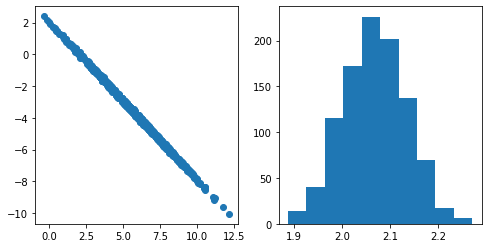

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(post[:, 1], post[:, 2])
axes[1].hist(post[:, 1] + post[:, 2]);

## 6.2 Post-treatment bias
T -> F -> H1 <- H0

In [31]:
# initial height, final height, treatment, presence of fungus
np.random.seed(888)
N = 100
h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(1, 0.5 - treatment*0.4, N)
h1 = h0 + np.random.normal(5-3*fungus, size=N)
d = pd.DataFrame({'h0': h0, 'h1': h1, 'treatment': treatment, 'fungus': fungus, 'h1': h1})
d.head()

,h0,h1,treatment,fungus
0,9.647598,11.890146,0,1
1,10.377753,14.950681,0,0
2,11.653494,17.555040,0,0
3,9.935105,12.714568,0,1
4,8.695001,13.496327,0,0


In [32]:
d.groupby('treatment').fungus.mean()

treatment
0    0.52
1    0.16
Name: fungus, dtype: float64

In [44]:
X = d[['treatment', 'fungus']]
y = d['h1'] / d['h0']
N = 1000
with pm.Model() as model:
    # Since the outcome and the predictor are both standardized, the intercept should end up very close to zero
    a = pm.Lognormal('a', 0, 0.2)
    b = pm.Normal('b', 0, 0.5, shape=X.shape[1])
    sigma = pm.Exponential('sigma', 1)
    y = pm.Normal('y',
                mu=a + pm.math.dot(X, b),
                sigma=sigma,
                observed=y)
    mean_q = pm.find_MAP()
    means = np.concatenate([mean_q[k].reshape(-1) for k in ['a', 'b', 'sigma']])
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, b, sigma]))  
    stds = np.sqrt(np.diagonal(cov_q))
    post = np.random.multivariate_normal(means, cov_q, size=N)
    print('means: ', means.round(2))
    print('stds:  ', stds.round(2))

logp = 22.09, ||grad|| = 434.95: 100%|██████████| 21/21 [00:00<00:00, 1818.53it/s]  


means:  [ 1.49  0.   -0.27  0.14]
stds:   [0.03 0.03 0.03 0.01]


The marginal posterior for bt, the effect of treatment, is solidly zero, with a tight interval. The treatment is
not associated with growth. The fungus seems to have hurt growth, however. Given that we know the treatment matters, because we built the simulation that way, what happened here?

The problem is that fungus is mostly a consequence of treatment. This is to say that fungus is a post-treatment variable. So when we control for fungus, the model is implicitly answering the question: **Once we already know whether or not a plant developed fungus, does soil treatment matter? The answer is “no,”** because soil treatment has its effects on growth through reducing fungus. But we actually want to know, based on the design of the experiment, is the impact of treatment on growth. To measure this properly, we should omit the post-treatment variable fungus.

> Note: It makes sense to control for pre-treatment differences, like the initial height h0, that might mask the causal influence of treatment. But including post-treatment variables can actually mask the treatment itself.
This doesn’t mean you don’t want the model that includes both treatment and fungus. The fact that including fungus zeros the coefficient for treatment suggests that the treatment works for exactly the anticipated reasons. It tells us about mechanism. But a correct inference about the treatment still depends upon omitting the post-treatment variable.

In [45]:
X = d[['treatment']]
y = d['h1'] / d['h0']
N = 1000
with pm.Model() as model:
    # Since the outcome and the predictor are both standardized, the intercept should end up very close to zero
    a = pm.Lognormal('a', 0, 0.2)
    b = pm.Normal('b', 0, 0.5, shape=X.shape[1])
    sigma = pm.Exponential('sigma', 1)
    y = pm.Normal('y',
                mu=a + pm.math.dot(X, b),
                sigma=sigma,
                observed=y)
    mean_q = pm.find_MAP()
    means = np.concatenate([mean_q[k].reshape(-1) for k in ['a', 'b', 'sigma']])
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, b, sigma]))  
    stds = np.sqrt(np.diagonal(cov_q))
    post = np.random.multivariate_normal(means, cov_q, size=N)
    print('means: ', means.round(2))
    print('stds:  ', stds.round(2))

logp = 26.989, ||grad|| = 4.0574: 100%|██████████| 17/17 [00:00<00:00, 1462.48it/s]  


means:  [1.35 0.1  0.18]
stds:   [0.03 0.04 0.01]


## 6.3 Collider bias
> Important: When you condition on a collider, it creates statistical—but not necessarily causal—associations among its causes. 

### Collider of false sorrow
Happier people are more likely to get married. Another variable that causally influences marriage is age: The more years you are alive, the more likely you are to eventually get married. Putting these three variables together, this is the causal model, with marriage being the collider:  
H -> M <- A  
 
Simulation design:  
(1) Each year, 20 people are born with uniformly distributed happiness values.  
(2) Each year, each person ages one year. Happiness does not change.  
(3) At age 18, individuals can become married. The odds of marriage each year are proportional to an individual’s happiness.  
(4) Once married, an individual remains married.  
(5) After age 65, individuals leave the sample. (They move to Spain.)

In [62]:
from scipy.special import expit
inv_logit = expit

np.random.seed(888)
N_years = 1000
N_births = 20
max_age = 65
aom = 18

H = M = A = np.empty(shape=0)
for t in range(N_years):
    A = A + 1
    A = np.append(A, np.repeat(1, N_births))
    H = np.append(H, np.linspace(-2, 2, N_births))
    M = np.append(M, np.repeat(0, N_births))
    mask = (A >= aom) & (M == 0)
    M[mask] = np.random.binomial(1, inv_logit(H[mask]-4), mask.sum())
    deaths = A > max_age
    A = A[~deaths]
    H = H[~deaths]
    M = M[~deaths]
    
d = pd.DataFrame({'age': A, 'married': M, 'happiness': H})
d.describe()

,age,married,happiness
count,1300.000000,1300.000000,1.300000e+03
mean,33.000000,0.293846,-8.335213e-17
std,18.768883,0.455698,1.214421e+00
min,1.000000,0.000000,-2.000000e+00
25%,17.000000,0.000000,-1.000000e+00
50%,33.000000,0.000000,-1.110223e-16
75%,49.000000,1.000000,1.000000e+00
max,65.000000,1.000000,2.000000e+00


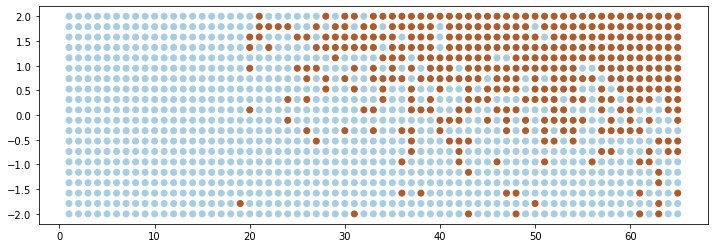

In [74]:
plt.figure(figsize=(12, 4))
plt.scatter(d.age, d.happiness, c=d.married, cmap='Paired')

In [77]:
d2 = d[d.age > 17].copy()
d2['A'] = (d2.age - 18) / (65 - 18)

In [88]:
with pm.Model() as m:
    a = pm.Normal('a', 0, 1, shape=d2['married'].nunique())
    b = pm.Normal('b', 0, 2)
    sigma = pm.Exponential('sigma', 1)
    mu = a[d2['married'].astype('category').cat.codes.values] + b * d2['A']
    happiness = pm.Normal('happiness', mu, sigma, observed=d2['happiness'])
    mean_q = pm.find_MAP()
    means = np.concatenate([mean_q[k].reshape(-1) for k in ['a', 'b', 'sigma']])
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, b, sigma]))  
    stds = np.sqrt(np.diagonal(cov_q))
    print('means: ', means)
    print('stds:  ', stds)

logp = -1,355.6, ||grad|| = 14.931: 100%|██████████| 16/16 [00:00<00:00, 1871.78it/s]  


means:  [-0.18797324  1.33727993 -0.84023086  0.98688523]
stds:   [0.06298421 0.08687716 0.11409826 0.02250547]


In [89]:
with pm.Model() as m:
    a = pm.Normal('a', 0, 1)
    b = pm.Normal('b', 0, 2)
    sigma = pm.Exponential('sigma', 1)
    mu = a + b * d2['A']
    happiness = pm.Normal('happiness', mu, sigma, observed=d2['happiness'])
    mean_q = pm.find_MAP()
    means = np.concatenate([mean_q[k].reshape(-1) for k in ['a', 'b', 'sigma']])
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, b, sigma]))  
    stds = np.sqrt(np.diagonal(cov_q))
    print('means: ', means)
    print('stds:  ', stds)

logp = -2,005.8, ||grad|| = 1,983.9: 100%|██████████| 10/10 [00:00<00:00, 2437.27it/s]


means:  [-6.99693162e-17 -4.44590295e-17  1.21318762e+00]
stds:   [0.07675015 0.13225976 0.02766089]


> Note: The pattern above is exactly what we should expect when we condition on a collider. The collider is marriage status. It a common consequence of age and happiness. As a result, when we condition on it, we induce a spurious association between the two causes. So it looks like that age is negatively associated with happiness. But this is just a statistical association, not a causal association. Once we know whether someone is married
or not, then their age does provide information about how happy they are.

### The haunted DAG
<= due to unmeasured causes

Suppose for example that we are interested in inferring the direct influence of both parents (P) and grandparents (G) on the educational achievement of children (C)...But suppose there are unmeasured, common influences (U) on parents and their children, such as neighborhoods, that are not shared by grandparents.

G -> P  
G ->C <- P  
P <- U -> C  

> Important: Now P is a common consequence of G and U, so if we condition on P, it will bias inference about G ! C, even if we never get to measure U. I don’t expect that fact to be immediately obvious.

In [93]:
N = 200
b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2

np.random.seed(888)
U = 2 * np.random.binomial(1, 0.5, N) - 1
G = np.random.normal(size=N)
P = np.random.normal(b_GP*G + b_U*U, size=N)
C = np.random.normal(b_PC*P + b_GC*G + b_U*U, size=N)
d = pd.DataFrame({'C': C, 'P': P, 'G': G, 'U': U})

In [95]:
X = d[['P', 'G']]
y = d['C']
N = 1000
with pm.Model() as model:
    # Since the outcome and the predictor are both standardized, the intercept should end up very close to zero
    a = pm.Lognormal('a', 0, 1)
    b = pm.Normal('b', 0, 1, shape=X.shape[1])
    sigma = pm.Exponential('sigma', 1)
    y = pm.Normal('y',
                mu=a + pm.math.dot(X, b),
                sigma=sigma,
                observed=y)
    mean_q = pm.find_MAP()
    means = np.concatenate([mean_q[k].reshape(-1) for k in ['a', 'b', 'sigma']])
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, b, sigma]))  
    stds = np.sqrt(np.diagonal(cov_q))
    post = np.random.multivariate_normal(means, cov_q, size=N)
    print('means: ', means.round(2))
    print('stds:  ', stds.round(2))

logp = -340.35, ||grad|| = 13.678: 100%|██████████| 21/21 [00:00<00:00, 2301.19it/s]  


means:  [ 0.23  1.86 -0.81  1.27]
stds:   [0.09 0.04 0.1  0.06]


> Note: The inferred effect of parents looks too big, almost twice as large as it should be. That isn’t surprising. Some of the correlation between P and C is due to U, and the model doesn’t know
about U. That’s a simple confound. More surprising is that the model is confident that the direct effect of grandparents is to hurt their grandkids. The regression is not wrong. But a causal interpretation of that association would be.  
More educated grandparents have more educated grandkids, but this effect arises entirely through parents. Why? Because we assumed it is so. The direct effect of G in the simulation is zero.  
So consider two different parents with the same education level, say for example at the median 50th centile. One of these parents
has a highly educated grandparent. The other has a poorly educated grandparent. The only probable way, in this example, for these parents to have the same education is if they live in different types of neighborhoods. We can’t see these neighborhood effects—we haven’t measured them, recall—but the influence of neighborhood is still transmitted to the children C. So for our mythical two P with the same education, the one with the highly educated G ends up with a less well educated C. The one with the less educated G ends up with the better educated C. G predicts lower C.

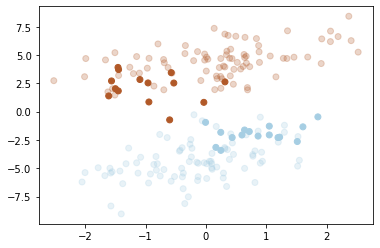

In [122]:
lower, upper = d.P.quantile([0.45, 0.6])
mask = (d.P > lower) & (d.P < upper)
plt.scatter(d.G[mask], d.C[mask], c=d.U[mask], cmap='Paired')
plt.scatter(d.G[~mask], d.C[~mask], c=d.U[~mask], alpha=0.25, cmap='Paired')

In [123]:
X = d[['P', 'G', 'U']]
y = d['C']
N = 1000
with pm.Model() as model:
    # Since the outcome and the predictor are both standardized, the intercept should end up very close to zero
    a = pm.Lognormal('a', 0, 1)
    b = pm.Normal('b', 0, 1, shape=X.shape[1])
    sigma = pm.Exponential('sigma', 1)
    y = pm.Normal('y',
                mu=a + pm.math.dot(X, b),
                sigma=sigma,
                observed=y)
    mean_q = pm.find_MAP()
    means = np.concatenate([mean_q[k].reshape(-1) for k in ['a', 'b', 'sigma']])
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, b, sigma]))  
    stds = np.sqrt(np.diagonal(cov_q))
    post = np.random.multivariate_normal(means, cov_q, size=N)
    print('means: ', means.round(2))
    print('stds:  ', stds.round(2))

logp = -301, ||grad|| = 1.7393: 100%|██████████| 28/28 [00:00<00:00, 2100.68it/s]     


means:  [ 0.18  1.15 -0.17  1.71  1.05]
stds:   [0.07 0.08 0.11 0.18 0.05]


> Warning: The grandparents example serves as an example of Simpson’s paradox: Including another predictor (P in this case) can reverse the direction of association between some other predictor (G) and the outcome (C). Usually, Simpson’s paradox is presented in cases where adding the new predictor helps us. But in this case, it misleads us. Simpson’s paradox is a statistical phenomenon.